In [ ]:
# Importing all the libraries
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
pwd

'/workspace'

In [ ]:
# Paths & JSON Loading
base_path = '/workspace/data/food41'
image_root = os.path.join(base_path, 'images')
meta_path = os.path.join(base_path, 'meta/meta')

# Checking paths
assert os.path.exists(base_path), f"Missing base directory: {base_path}"
assert os.path.exists(image_root), f"Missing images directory: {image_root}"
assert os.path.exists(meta_path), f"Missing meta directory: {meta_path}"

# Loading JSON files
with open(os.path.join(meta_path, 'train.json'), 'r') as f:
    train_json = json.load(f)
with open(os.path.join(meta_path, 'test.json'), 'r') as f:
    test_json = json.load(f)



In [ ]:
# Fixing Path Formatting
train_data = []
for _, files in train_json.items():
    train_data.extend(files)

test_data = []
for _, files in test_json.items():
    test_data.extend(files)

# Initial checks
print(f"Loaded training samples: {len(train_data)}")
print(f"Loaded testing samples: {len(test_data)}")

# Getting labels from paths (first folder = class name)
train_labels = [path.split('/')[0] for path in train_data]
label_counts = Counter(train_labels)
print(f"\nNumber of unique classes: {len(label_counts)}")


Loaded training samples: 75750
Loaded testing samples: 25250

Number of unique classes: 101


In [ ]:
# Train-Validation Split
train_paths, val_paths, train_targets, val_targets = train_test_split(
    train_data,
    train_labels,
    test_size=0.2,
    stratify=train_labels,
    random_state=42
)



In [ ]:
# Encoding Labels
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

train_encoded = label_encoder.transform(train_targets)
val_encoded = label_encoder.transform(val_targets)
test_encoded = label_encoder.transform([x.split('/')[0] for x in test_data])



In [ ]:
# Defining Transforms
image_size = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transform_val_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])





In [ ]:
# Dataset Class
class Food101Dataset(Dataset):
    def __init__(self, image_paths, labels, root_dir, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, img_rel_path)

        if not img_path.endswith(".jpg"):
            img_path += ".jpg"

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Missing file: {img_path}")

        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Creating Dataset & DataLoaders
batch_size = 32

train_dataset = Food101Dataset(train_paths, train_encoded, root_dir=image_root, transform=transform_train)
val_dataset = Food101Dataset(val_paths, val_encoded, root_dir=image_root, transform=transform_val_test)
test_dataset = Food101Dataset(test_data, test_encoded, root_dir=image_root, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [ ]:
# Sanity Output
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 1894
Validation batches: 474
Test batches: 790


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from torchvision import models
import torch.nn as nn

# Loading pretrained ResNet50
resnet_finetune = models.resnet50(pretrained=True)

# Freezing everything
for param in resnet_finetune.parameters():
    param.requires_grad = False

# Unfreezing layer 3 and layer 4
for name, param in resnet_finetune.named_parameters():

    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


# Replacing the final fully connected layer
resnet_finetune.fc = nn.Linear(resnet_finetune.fc.in_features, 101)

# Moving to GPU
resnet_finetune = resnet_finetune.to(device)


/workspace/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim

# Settiing different learning rates
optimizer = optim.Adam([
    {'params': resnet_finetune.fc.parameters(), 'lr': 0.002},
    {'params': [param for name, param in resnet_finetune.named_parameters() if "layer4" in name], 'lr': 0.0005}
])

# Scheduler and loss
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


In [ ]:
# Model training
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=3):
    import time
    import copy

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    patience_counter = 0

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Early stopping logic
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    print(f"EarlyStopping counter: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print(f"\n Early stopping triggered at epoch {epoch+1}")
                        model.load_state_dict(best_model_wts)
                        return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

            print(f"{phase} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history




In [ ]:
resnet_finetune, train_loss_f, val_loss_f, train_acc_f, val_acc_f = train_model(
    resnet_finetune,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=20,
    patience=5

)


Epoch 1/20
------------------------------
train Loss: 2.8704 | Acc: 0.4104
val Loss: 2.3490 | Acc: 0.5601
Epoch 2/20
------------------------------
train Loss: 2.2804 | Acc: 0.5680
val Loss: 2.0974 | Acc: 0.6283
Epoch 3/20
------------------------------
train Loss: 1.9331 | Acc: 0.6698
val Loss: 1.8557 | Acc: 0.6983
Epoch 4/20
------------------------------
train Loss: 1.8533 | Acc: 0.6951
val Loss: 1.8087 | Acc: 0.7110
Epoch 5/20
------------------------------
train Loss: 1.7932 | Acc: 0.7129
val Loss: 1.8007 | Acc: 0.7167
Epoch 6/20
------------------------------
train Loss: 1.7754 | Acc: 0.7176
EarlyStopping counter: 1/5
val Loss: 1.7973 | Acc: 0.7157
Epoch 7/20
------------------------------
train Loss: 1.7754 | Acc: 0.7159
EarlyStopping counter: 2/5
val Loss: 1.7958 | Acc: 0.7142
Epoch 8/20
------------------------------
train Loss: 1.7734 | Acc: 0.7176
EarlyStopping counter: 3/5
val Loss: 1.8015 | Acc: 0.7158
Epoch 9/20
------------------------------
train Loss: 1.7692 | Acc: 0.7

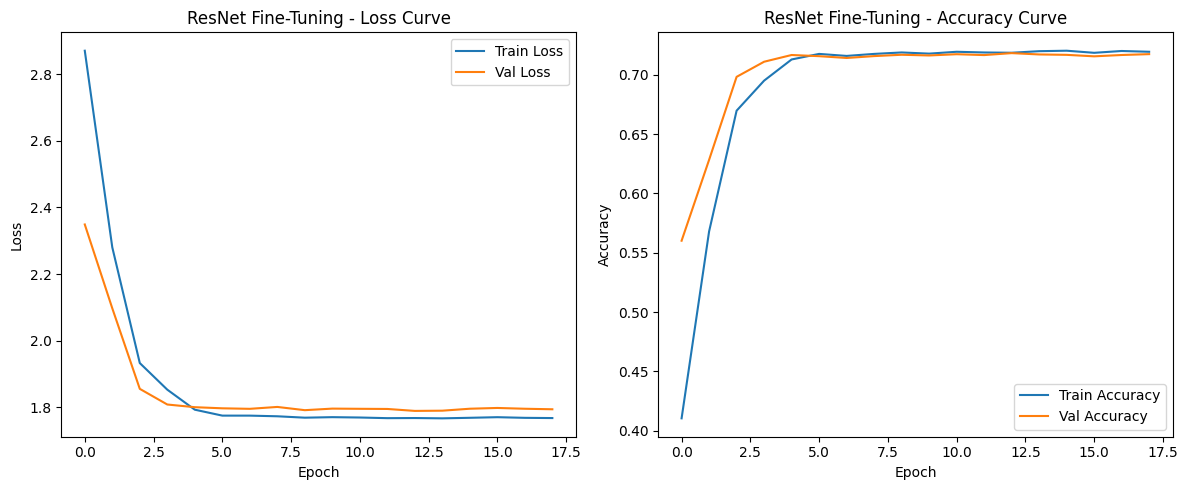

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_f, label='Train Loss')
plt.plot(val_loss_f, label='Val Loss')
plt.title('ResNet Fine-Tuning - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_f, label='Train Accuracy')
plt.plot(val_acc_f, label='Val Accuracy')
plt.title('ResNet Fine-Tuning - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
# Evaluating Model
def evaluate_model(model, test_loader, label_encoder, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    decoded_labels = label_encoder.inverse_transform(all_labels)
    decoded_preds = label_encoder.inverse_transform(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n Test Accuracy: {acc:.4f}")
    print("\n Classification Report:\n")
    print(classification_report(decoded_labels, decoded_preds, target_names=label_encoder.classes_))


In [ ]:
from collections import defaultdict
# Accuracy Analysis
def evaluate_top_bottom_classes(model, test_loader, label_encoder, device):
    model.eval()
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            _, preds = torch.max(outputs, 1)

            for label, pred in zip(labels.cpu().numpy(), preds.cpu().numpy()):
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

    class_accuracies = {
        label_encoder.inverse_transform([k])[0]: class_correct[k] / class_total[k]
        for k in class_total
    }

    sorted_acc = sorted(class_accuracies.items(), key=lambda x: x[1], reverse=True)

    print("\nTop 5 Most Accurate Classes:")
    for cls, acc in sorted_acc[:5]:
        print(f"{cls:25s}: {acc:.2%}")

    print("\n Bottom 5 Least Accurate Classes:")
    for cls, acc in sorted_acc[-5:]:
        print(f"{cls:25s}: {acc:.2%}")


In [ ]:
evaluate_model(resnet_finetune, test_loader, label_encoder, device)
evaluate_top_bottom_classes(resnet_finetune, test_loader, label_encoder, device)



 Test Accuracy: 0.7737

 Classification Report:

                         precision    recall  f1-score   support

              apple_pie       0.63      0.43      0.51       250
         baby_back_ribs       0.79      0.77      0.78       250
                baklava       0.81      0.87      0.84       250
         beef_carpaccio       0.89      0.81      0.85       250
           beef_tartare       0.73      0.77      0.75       250
             beet_salad       0.66      0.68      0.67       250
               beignets       0.84      0.89      0.86       250
               bibimbap       0.87      0.90      0.89       250
          bread_pudding       0.64      0.54      0.59       250
      breakfast_burrito       0.68      0.64      0.66       250
             bruschetta       0.67      0.60      0.63       250
           caesar_salad       0.85      0.83      0.84       250
                cannoli       0.85      0.85      0.85       250
          caprese_salad       0.68     